<a href="https://colab.research.google.com/github/Seemab-zakir/corona-classification-Cnn/blob/main/corona_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from keras.preprocessing import image
import os
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.applications import vgg16 
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [3]:
!unzip /content/gdrive/MyDrive/Coronaro_dataset.zip 

Archive:  /content/gdrive/MyDrive/Coronaro_dataset.zip
 extracting: Coronaro_dataset/background/BG_pz01.jpeg  
 extracting: Coronaro_dataset/background/BG_pz02.jpeg  
 extracting: Coronaro_dataset/background/BG_pz03a.jpeg  
 extracting: Coronaro_dataset/background/BG_pz03b.jpeg  
 extracting: Coronaro_dataset/background/BG_pz04.jpeg  
 extracting: Coronaro_dataset/background/BG_pz05.jpeg  
 extracting: Coronaro_dataset/background/BG_pz06.jpeg  
 extracting: Coronaro_dataset/background/BG_pz07.jpeg  
 extracting: Coronaro_dataset/background/BG_pz08a.jpeg  
 extracting: Coronaro_dataset/background/BG_pz09.jpeg  
 extracting: Coronaro_dataset/background/BG_pz10.jpeg  
 extracting: Coronaro_dataset/background/BG_pz11.jpeg  
 extracting: Coronaro_dataset/background/BG_pz12.jpeg  
 extracting: Coronaro_dataset/background/BG_pz13.jpeg  
 extracting: Coronaro_dataset/background/BG_pz14.jpeg  
 extracting: Coronaro_dataset/background/BG_pz15.jpeg  
 extracting: Coronaro_dataset/background/BG_pz

In [4]:
disease_types=['background', 'stenosis']
data_dir = '/content/Coronaro_dataset'
train_dir = os.path.join(data_dir)

In [5]:
data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        data.append(['{}/{}'.format(sp, file), defects_id, sp])      
df = pd.DataFrame(data, columns=['File', 'DiseaseID','DiseaseType'])

In [6]:
df.head()

,File,DiseaseID,DiseaseType
0,background/BG_pz29.jpeg,0,background
1,background/BG_pz36.jpeg,0,background
2,background/BG_pz11.jpeg,0,background
3,background/BG_pz33.jpeg,0,background
4,background/BG_pz02.jpeg,0,background


In [7]:
len(data)

100

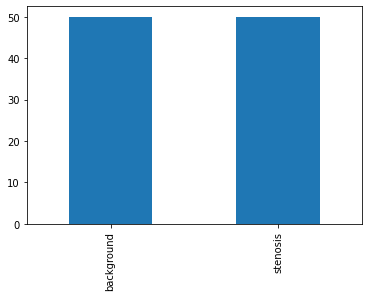

In [8]:
df['DiseaseType'].value_counts().plot.bar()

In [6]:
#image size
image_shape = (224,224,3)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
#split train in train-valid
trainVal_df, test_Valdf = train_test_split(train_df, test_size=0.15,random_state=42)



In [8]:
from keras_preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(
    horizontal_flip=True,
    # vertical_flip=True,
    # rotation_range=90,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    # shear_range=0.1,
    # brightness_range=[0.8, 1.2]
    )

In [9]:
len(train_df),len(test_df)

(85, 15)

In [10]:
train_df

,File,DiseaseID,DiseaseType
4,background/BG_pz36.jpeg,0,background
76,stenosis/S_pz27.jpeg,1,stenosis
77,stenosis/S_pz26a.jpeg,1,stenosis
12,background/BG_pz01.jpeg,0,background
31,background/BG_pz31b.jpeg,0,background
...,...,...,...
60,stenosis/S_pz15.jpeg,1,stenosis
71,stenosis/S_pz05.jpeg,1,stenosis
14,background/BG_pz33.jpeg,0,background
92,stenosis/S_pz26b.jpeg,1,stenosis


In [11]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df,directory='/content/Coronaro_dataset',
    x_col="File",
    y_col="DiseaseType",
    target_size=image_shape[0:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

Found 85 validated image filenames belonging to 2 classes.


In [12]:
val_generator = datagen.flow_from_dataframe(dataframe=trainVal_df,directory='/content/Coronaro_dataset',
    x_col="File",
    y_col="DiseaseType",
    target_size=image_shape[0:2],
    batch_size=32,
    class_mode='categorical'
    )

Found 72 validated image filenames belonging to 2 classes.


In [13]:
test_generator = datagen.flow_from_dataframe(dataframe=test_df,directory='/content/Coronaro_dataset',
    x_col="File",
    y_col="DiseaseType",
    target_size=image_shape[0:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False
    )

Found 15 validated image filenames belonging to 2 classes.


In [14]:
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers, Sequential,Model
from keras import optimizers

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the layers 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

58889256/58889256 [==============================] - 0s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fad60b298e0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad60ae94c0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad60ae9940> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fad60ae9760> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad60a4f1f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad5cd1b9a0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fad60ae9c10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad5cd21250> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad5cd21100> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad5cd28dc0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fad60a4fbe0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fad5cd2f790> False
<keras.layers.convolutional.con

In [15]:
model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model.add(vgg_conv)
          
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
results = model.fit(train_generator,epochs=20,
                              validation_data=test_generator,verbose=1)

Epoch 1/20
3/3 [==============================] - 58s 19s/step - loss: 2.1222 - accuracy: 0.5647 - val_loss: 0.6326 - val_accuracy: 0.6000
Epoch 2/20
3/3 [==============================] - 60s 22s/step - loss: 0.7172 - accuracy: 0.4588 - val_loss: 4.3605 - val_accuracy: 0.4000
Epoch 3/20
3/3 [==============================] - 56s 19s/step - loss: 1.4024 - accuracy: 0.6471 - val_loss: 0.6448 - val_accuracy: 0.6000
Epoch 4/20
3/3 [==============================] - 55s 22s/step - loss: 1.7184 - accuracy: 0.4941 - val_loss: 0.7188 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 55s 18s/step - loss: 0.7045 - accuracy: 0.5176 - val_loss: 0.6541 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 63s 23s/step - loss: 0.6727 - accuracy: 0.5412 - val_loss: 0.6384 - val_accuracy: 0.6667
Epoch 7/20
3/3 [==============================] - 55s 18s/step - loss: 0.6830 - accuracy: 0.5412 - val_loss: 0.6934 - val_accuracy: 0.4000
Epoch 8/20
3/3 [===========

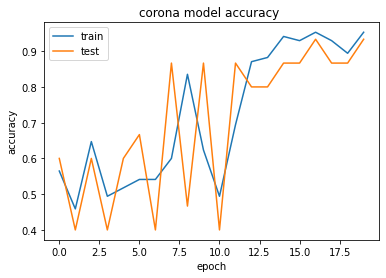

In [20]:
import matplotlib.pyplot as plt
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('corona model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

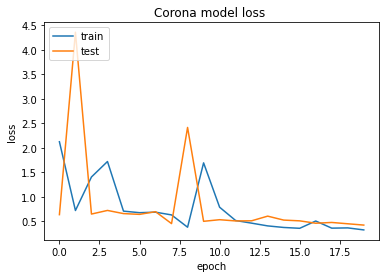

In [21]:
import matplotlib.pyplot as plt
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Corona model loss ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.evaluate(test_generator)

1/1 [==============================] - 8s 8s/step - loss: 0.4246 - accuracy: 0.8667


[0.42462998628616333, 0.8666666746139526]

In [23]:
model.evaluate(val_generator)

3/3 [==============================] - 33s 9s/step - loss: 0.3019 - accuracy: 0.9444


[0.30188024044036865, 0.9444444179534912]

In [24]:
!mkdir results

In [25]:
# to save model and weights
model_json = model.to_json()
with open("results/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('results/model_weights.h5')

In [26]:
y_score=model.predict(test_generator)

1/1 [==============================] - 7s 7s/step


In [27]:
class_names=list(test_generator.class_indices.values())
class_names

[0, 1]

In [28]:
print(y_score.shape)
y_pred=np.argmax(y_score,axis=1)#return col which has max value
y_test=test_generator.classes#axis 0=rows and axis 1=col

(15, 2)


In [29]:
np.unique(y_pred,return_counts=True)

(array([0, 1]), array([10,  5]))

In [30]:
test_generator.classes

[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]

In [31]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average='macro'))

0.9333333333333333
0.9282296650717703


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.83      0.91         6

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



In [33]:
from PIL import Image
import numpy as np
from skimage import transform
def load(File):
   np_image = Image.open(File)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
image = load('/content/Coronaro_dataset/stenosis/S_pz03.jpeg')
img=np.argmax(model.predict(image),1)
image2=load('/content/Coronaro_dataset/background/BG_pz03a.jpeg')
img2=np.argmax(model.predict(image2),1)


1/1 [==============================] - 1s 521ms/step


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


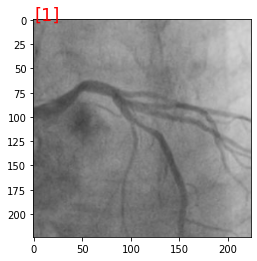

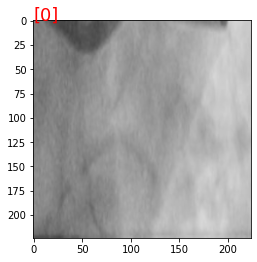

In [34]:
from skimage import io
# Load the image
org_img = io.imread('/content/Coronaro_dataset/stenosis/S_pz03.jpeg')
org_img = transform.resize(org_img, (224, 224))
plt.imshow(org_img)
plt.text(0.5, 0.5, img, fontsize=18, color='red')
plt.show()


# Load the image
org_img2 = io.imread('/content/Coronaro_dataset/background/BG_pz03a.jpeg')
org_img2 = transform.resize(org_img2, (224, 224))
plt.imshow(org_img2)
plt.text(0, 0, img2, fontsize=18, color='red')
plt.show()

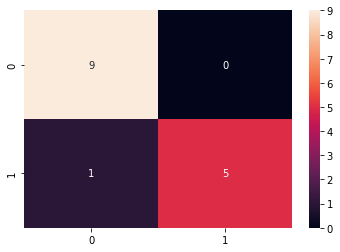

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=list(class_names))
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               #display_labels=list(class_names))
sns.heatmap(cm, annot=True, fmt="d")
#disp.plot(cmap='Blues')
plt.show()

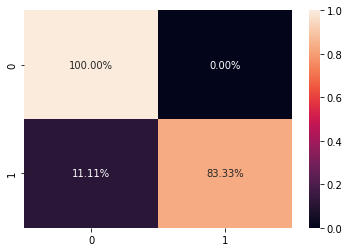

In [36]:
cm = cm.astype('float') / cm.sum(axis=1)
sns.heatmap(cm, annot=True, 
            fmt='.2%')

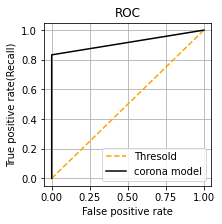

In [37]:
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds2=roc_curve(y_test,y_pred)
plt.figure(figsize=(3,3))
plt.plot([0, 1], [0, 1], '--',color='orange',label='Thresold')
plt.plot(fpr1, tpr1,color='black',label='corona model')
plt.ylabel('True positive rate(Recall)')
plt.xlabel('False positive rate')
plt.title('ROC')
plt.grid()
plt.legend()
plt.show()